# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


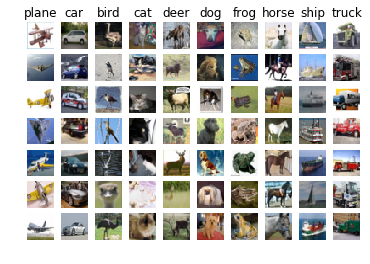

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


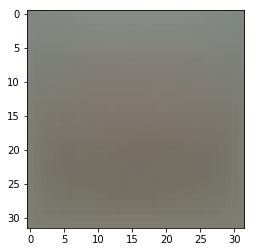

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.078191


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [29]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 22.220594 analytic: 22.220594, relative error: 3.961042e-12
numerical: 6.529298 analytic: 6.529298, relative error: 7.304727e-12
numerical: 9.296810 analytic: 9.296810, relative error: 9.986264e-12
numerical: 3.968997 analytic: 3.968997, relative error: 5.463963e-11
numerical: 5.001135 analytic: 5.001135, relative error: 7.423477e-11
numerical: -0.056746 analytic: -0.056746, relative error: 1.322921e-08
numerical: -8.591026 analytic: -8.591026, relative error: 7.863937e-12
numerical: -8.221616 analytic: -8.221616, relative error: 1.862820e-11
numerical: -8.622419 analytic: -8.622419, relative error: 1.824313e-11
numerical: -9.997363 analytic: -9.997363, relative error: 1.506961e-11
numerical: -21.220622 analytic: -21.220622, relative error: 1.611482e-11
numerical: -32.767617 analytic: -32.767617, relative error: 2.804755e-12
numerical: 3.981365 analytic: 3.981365, relative error: 8.431288e-11
numerical: -9.654656 analytic: -9.654656, relative error: 3.621137e-11
numerical: -

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *Yes,it is possible that result will not match exactly.the reason for such a discrepancy could be that SVM loss fuction is not strictly speaking differentiable and gradient around zero is not continuous.It is not a reason for concern.Example:you add a small turbulence to one dimension causes the score jupmed from 0 to s_j-s_{y_i}+1 or inverse*

In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.078191e+00 computed in 0.165727s
Vectorized loss: 9.078191e+00 computed in 0.007254s
difference: 0.000000


In [30]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.293755s
Vectorized loss and gradient: computed in 0.012646s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [31]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 796.252636
iteration 100 / 1500: loss 288.804219
iteration 200 / 1500: loss 108.657060
iteration 300 / 1500: loss 43.467247
iteration 400 / 1500: loss 19.208208
iteration 500 / 1500: loss 10.323389
iteration 600 / 1500: loss 7.513943
iteration 700 / 1500: loss 5.951132
iteration 800 / 1500: loss 5.233370
iteration 900 / 1500: loss 5.406529
iteration 1000 / 1500: loss 5.041627
iteration 1100 / 1500: loss 4.872486
iteration 1200 / 1500: loss 6.057923
iteration 1300 / 1500: loss 5.253906
iteration 1400 / 1500: loss 4.920281
That took 7.081920s


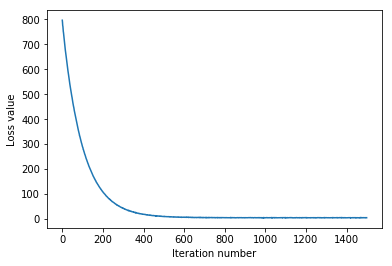

In [32]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [36]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.370082
validation accuracy: 0.368000


In [57]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 1e-6,1e-5,1e-4,2e-7,2e-6,2e-5]
regularization_strengths = [0,0.2,0.5,0.8,1,5,1e1,1e2, 1e3]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
num_iters=1500


for lr in learning_rates:
    for reg in regularization_strengths:
#         results={(lr,reg):(0,0)}
        svm = LinearSVM()
        tic = time.time()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=num_iters, verbose=True)
        toc = time.time()
        print 'That took %fs' % (toc - tic)
        y_train_pred = svm.predict(X_train)
        train_acc=np.mean(y_train == y_train_pred)
        print 'training accuracy: %f' % (train_acc)
        y_val_pred = svm.predict(X_val)
        val_acc=np.mean(y_val == y_val_pred)
        print 'validation accuracy: %f' % (val_acc)
        results[(lr,reg)]=(train_acc,val_acc)
        print (lr,reg),':',(train_acc,val_acc)
        if val_acc>best_val:
            best_val=val_acc
            best_svm=svm
            
        
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 24.207988
iteration 100 / 1500: loss 11.117986
iteration 200 / 1500: loss 10.873797
iteration 300 / 1500: loss 9.805575
iteration 400 / 1500: loss 9.156616
iteration 500 / 1500: loss 9.045656
iteration 600 / 1500: loss 7.742008
iteration 700 / 1500: loss 6.579324
iteration 800 / 1500: loss 6.448979
iteration 900 / 1500: loss 8.548311
iteration 1000 / 1500: loss 6.776775
iteration 1100 / 1500: loss 7.017763
iteration 1200 / 1500: loss 5.865925
iteration 1300 / 1500: loss 6.291190
iteration 1400 / 1500: loss 6.424871
That took 6.364956s
training accuracy: 0.298857
validation accuracy: 0.293000
(1e-07, 0) : (0.29885714285714288, 0.29299999999999998)
iteration 0 / 1500: loss 24.438674
iteration 100 / 1500: loss 10.605804
iteration 200 / 1500: loss 8.828430
iteration 300 / 1500: loss 7.737849
iteration 400 / 1500: loss 7.080310
iteration 500 / 1500: loss 8.303505
iteration 600 / 1500: loss 7.906827
iteration 700 / 1500: loss 7.736138
iteration 800 / 1500: loss 6.494

iteration 200 / 1500: loss 6.713684
iteration 300 / 1500: loss 5.423770
iteration 400 / 1500: loss 5.285535
iteration 500 / 1500: loss 6.915709
iteration 600 / 1500: loss 5.631575
iteration 700 / 1500: loss 5.248943
iteration 800 / 1500: loss 5.500850
iteration 900 / 1500: loss 6.492880
iteration 1000 / 1500: loss 5.836324
iteration 1100 / 1500: loss 5.310330
iteration 1200 / 1500: loss 5.515405
iteration 1300 / 1500: loss 5.196480
iteration 1400 / 1500: loss 4.684875
That took 6.227825s
training accuracy: 0.355000
validation accuracy: 0.345000
(1e-06, 0.8) : (0.35499999999999998, 0.34499999999999997)
iteration 0 / 1500: loss 24.576721
iteration 100 / 1500: loss 7.933735
iteration 200 / 1500: loss 6.226871
iteration 300 / 1500: loss 6.391998
iteration 400 / 1500: loss 4.909195
iteration 500 / 1500: loss 5.383737
iteration 600 / 1500: loss 5.260722
iteration 700 / 1500: loss 5.595128
iteration 800 / 1500: loss 5.658371
iteration 900 / 1500: loss 5.486413
iteration 1000 / 1500: loss 5.44

iteration 200 / 1500: loss 19.606748
iteration 300 / 1500: loss 26.719553
iteration 400 / 1500: loss 18.125228
iteration 500 / 1500: loss 14.866538
iteration 600 / 1500: loss 18.472458
iteration 700 / 1500: loss 18.889963
iteration 800 / 1500: loss 21.567183
iteration 900 / 1500: loss 28.303057
iteration 1000 / 1500: loss 19.102897
iteration 1100 / 1500: loss 18.053544
iteration 1200 / 1500: loss 14.979728
iteration 1300 / 1500: loss 13.606029
iteration 1400 / 1500: loss 20.605096
That took 6.137698s
training accuracy: 0.313980
validation accuracy: 0.279000
(1e-05, 10.0) : (0.31397959183673468, 0.27900000000000003)
iteration 0 / 1500: loss 24.845639
iteration 100 / 1500: loss 22.065083
iteration 200 / 1500: loss 25.248826
iteration 300 / 1500: loss 16.242091
iteration 400 / 1500: loss 15.832383
iteration 500 / 1500: loss 20.102522
iteration 600 / 1500: loss 13.682083
iteration 700 / 1500: loss 20.650373
iteration 800 / 1500: loss 13.839906
iteration 900 / 1500: loss 16.395951
iteration

That took 6.262359s
training accuracy: 0.211061
validation accuracy: 0.212000
(0.0001, 1000.0) : (0.21106122448979592, 0.21199999999999999)
iteration 0 / 1500: loss 24.207390
iteration 100 / 1500: loss 9.590513
iteration 200 / 1500: loss 8.461402
iteration 300 / 1500: loss 8.680668
iteration 400 / 1500: loss 7.647464
iteration 500 / 1500: loss 6.882063
iteration 600 / 1500: loss 7.995781
iteration 700 / 1500: loss 5.782391
iteration 800 / 1500: loss 6.316381
iteration 900 / 1500: loss 6.643109
iteration 1000 / 1500: loss 7.483547
iteration 1100 / 1500: loss 6.202044
iteration 1200 / 1500: loss 7.342545
iteration 1300 / 1500: loss 6.203937
iteration 1400 / 1500: loss 5.468423
That took 6.217760s
training accuracy: 0.323755
validation accuracy: 0.335000
(2e-07, 0) : (0.32375510204081631, 0.33500000000000002)
iteration 0 / 1500: loss 24.336883
iteration 100 / 1500: loss 11.003767
iteration 200 / 1500: loss 8.236775
iteration 300 / 1500: loss 7.223739
iteration 400 / 1500: loss 6.867995
it

iteration 100 / 1500: loss 7.927979
iteration 200 / 1500: loss 7.307386
iteration 300 / 1500: loss 6.398229
iteration 400 / 1500: loss 6.672400
iteration 500 / 1500: loss 7.147697
iteration 600 / 1500: loss 6.718046
iteration 700 / 1500: loss 6.243438
iteration 800 / 1500: loss 6.914073
iteration 900 / 1500: loss 6.495179
iteration 1000 / 1500: loss 6.131515
iteration 1100 / 1500: loss 7.091725
iteration 1200 / 1500: loss 6.728119
iteration 1300 / 1500: loss 6.005358
iteration 1400 / 1500: loss 6.713027
That took 6.229827s
training accuracy: 0.351306
validation accuracy: 0.362000
(2e-06, 0.8) : (0.35130612244897957, 0.36199999999999999)
iteration 0 / 1500: loss 25.470917
iteration 100 / 1500: loss 7.388575
iteration 200 / 1500: loss 6.291617
iteration 300 / 1500: loss 7.206913
iteration 400 / 1500: loss 7.064880
iteration 500 / 1500: loss 7.503829
iteration 600 / 1500: loss 6.315620
iteration 700 / 1500: loss 6.506894
iteration 800 / 1500: loss 6.189373
iteration 900 / 1500: loss 5.604

iteration 100 / 1500: loss 25.908345
iteration 200 / 1500: loss 40.046535
iteration 300 / 1500: loss 32.510794
iteration 400 / 1500: loss 45.489969
iteration 500 / 1500: loss 52.932834
iteration 600 / 1500: loss 31.963298
iteration 700 / 1500: loss 37.147935
iteration 800 / 1500: loss 33.381205
iteration 900 / 1500: loss 22.483360
iteration 1000 / 1500: loss 53.518253
iteration 1100 / 1500: loss 32.547773
iteration 1200 / 1500: loss 44.480274
iteration 1300 / 1500: loss 43.125754
iteration 1400 / 1500: loss 43.456000
That took 6.208171s
training accuracy: 0.281837
validation accuracy: 0.280000
(2e-05, 10.0) : (0.28183673469387754, 0.28000000000000003)
iteration 0 / 1500: loss 25.542829
iteration 100 / 1500: loss 38.122051
iteration 200 / 1500: loss 63.608672
iteration 300 / 1500: loss 51.539820
iteration 400 / 1500: loss 45.676384
iteration 500 / 1500: loss 35.906913
iteration 600 / 1500: loss 31.058764
iteration 700 / 1500: loss 31.907971
iteration 800 / 1500: loss 35.563256
iteration

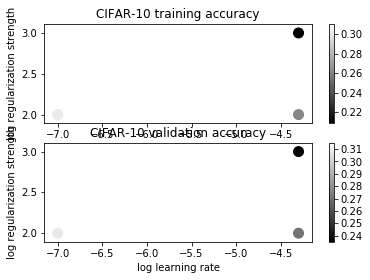

In [50]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [51]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.294000


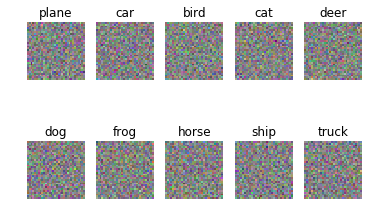

In [52]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*